# Notebook for enriching protein-biological process and drug-biological process edges

In our MOA project, we want to use the [Gene Ontology Biological Process](http://geneontology.org/docs/ontology-documentation/) (BP) as sink nodes, so we need to incorporate this information into the KG.

In [1]:
import pandas as pd
from tqdm import tqdm
import os.path as osp

from matplotlib_venn import venn2_unweighted
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
import requests
import re

/Users/laurendelong/neurosymbolic-mechanism/nesy_venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load KG files

In [2]:
KG_DIR = '../data/kg/'

Load in the processed OpenBioLink KG with only drug-protein and protein-protein edges:

In [3]:
openbiolink_df = pd.read_csv(f'{KG_DIR}/openbiolink_filtered.tsv', sep='\t')
openbiolink_df.head(2)

,source,target,polarity
0,pubchem.compound:10607,ncbigene:3553,1
1,pubchem.compound:10607,ncbigene:203068,-1


Load in the processed Custom/In-House KG with only drug-protein and protein-protein edges:

In [4]:
custom_df = pd.read_csv(f'{KG_DIR}/customkg_filtered.tsv', sep='\t')
custom_df.head(2)

,source,target,polarity
0,pubchem.compound:4943,ncbigene:2562,1
1,pubchem.compound:4943,ncbigene:2563,1


# Subset proteins for BP enrichments

Here, we are getting all of the proteins in the KGs:

In [5]:
openbiolink_proteins = set()

for source, target, rel in tqdm(openbiolink_df.values):
    if 'ncbigene' in source:
        openbiolink_proteins.add(source)

    if 'ncbigene' in target:
        openbiolink_proteins.add(target)

len(openbiolink_proteins)

100%|██████████| 41441/41441 [00:00<00:00, 1541237.59it/s]


4618

In [6]:
custom_proteins = set()

for source, target, rel in tqdm(custom_df.values):
    if 'ncbigene' in source:
        custom_proteins.add(source)

    if 'ncbigene' in target:
        custom_proteins.add(target)

len(custom_proteins)


100%|██████████| 51400/51400 [00:00<00:00, 1581432.66it/s]


8229

# Map the protein to their GO annotations

Now that we have the protein IDs, we can map them to corresponding GO annotations. We got these annotations from the [GO FTP download page](https://ftp.ncbi.nlm.nih.gov/gene/DATA/).

In [7]:
MAPPING_DIR = '../data/mappings'

In [8]:
process_df = pd.read_csv(
    f'{MAPPING_DIR}/gene2go.tsv', sep='\t', dtype=str,
)

process_df = process_df[process_df['#tax_id'] == '9606']
process_df.head(2)

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
812115,9606,1,GO:0003674,ND,enables,molecular_function,-,Function
812116,9606,1,GO:0005576,HDA,located_in,extracellular region,27068509,Component


In [9]:
process_df.Category.value_counts()

Category
Process      157388
Component    103600
Function      84844
Name: count, dtype: int64

As we can see from the above, all three GO ontologies are included in this.

To make this GO dataframe work with our other dataframes, we need all the NCBI gene IDs to start with the prefix, "ncbigene".

In [10]:
process_df['GeneID'] = 'ncbigene:' + process_df['GeneID']

Now, let's investigate what the overlap is between the NCBI gene IDs in the GO and in the OpenBioLink KG:

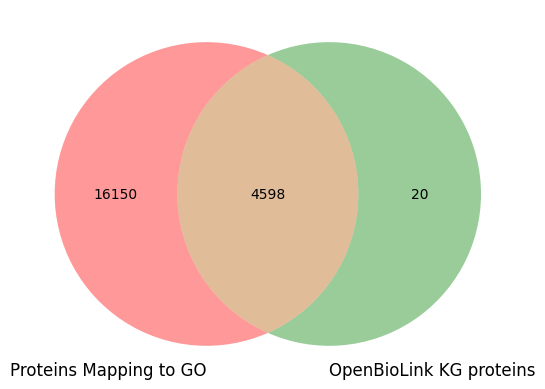

In [11]:
venn2_unweighted(
    [set(process_df['GeneID'].unique()), openbiolink_proteins],
    set_labels=['Proteins Mapping to GO', 'OpenBioLink KG proteins']
)

And let's investigate what the overlap is between the NCBI gene IDs in the GO and in the Custom KG:

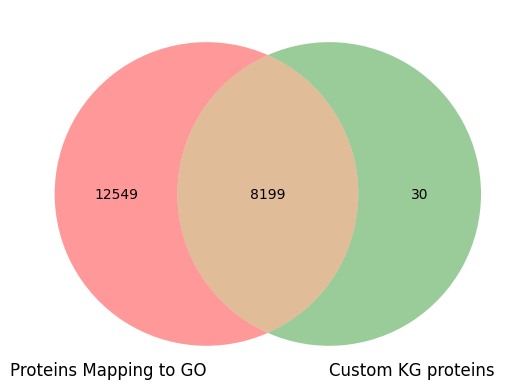

In [12]:
venn2_unweighted(
    [set(process_df['GeneID'].unique()), custom_proteins],
    set_labels=['Proteins Mapping to GO', 'Custom KG proteins']
)

And for all proteins between the two?

In [13]:
all_protein_in_kg = custom_proteins.union(openbiolink_proteins)

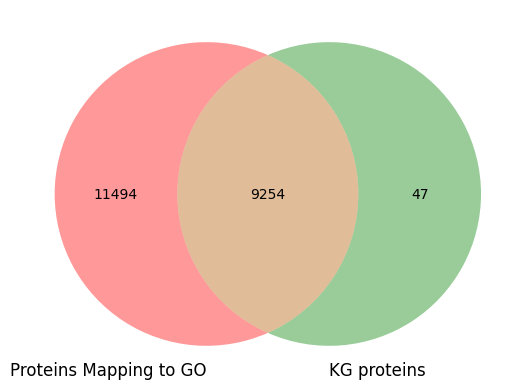

In [14]:
venn2_unweighted(
    [set(process_df['GeneID'].unique()), all_protein_in_kg],
    set_labels=['Proteins Mapping to GO', 'KG proteins']
)

# GO Annotations

Let's see what GO Annotations are connected to our proteins.

First, get all the proteins between the two KGs:

In [15]:
len(all_protein_in_kg)

9301

In [16]:
filtered_df = process_df[process_df['GeneID'].isin(all_protein_in_kg)]
filtered_df.to_csv(f'{MAPPING_DIR}/in_kg_go_terms.tsv', sep='\t', index=False)

Remind our selves what's in the original gene2GO dataframe:

In [17]:
filtered_df.head(2)

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
812128,9606,ncbigene:2,GO:0001553,IEA,involved_in,luteinization,-,Process
812129,9606,ncbigene:2,GO:0001869,IDA,involved_in,"negative regulation of complement activation, ...",12538697,Process


Let's map GO IDs here to their respective GO terms so that we can use it later.

In [18]:
id2term = {row['GO_ID']: row['GO_term'] for _, row in filtered_df.iterrows()}

What's happening here? We are looping through the above dataframe and extracting the GO terms.

For each gene ID, we keep a set of associated GO terms.

We also separate the GO terms by BP, molecular function, and cellular component so that we can keep track of which type of GO term is associated with which gene.

In [19]:
from collections import defaultdict

In [20]:
# Set of GO terms to remove since they are too general
terms_to_remove = {
    'GO:0046677',	# response to antibiotic
    'GO:0065003',	# protein-containing complex assembly
    'GO:0009636',	# response to toxic substance
    'GO:0000003', 	# reproduction
    'GO:0008152',	# metabolic process
    'GO:0009056',	# catabolic process
    'GO:0032259',	# methylation
    'GO:0016310',	# phosphorylation
    'GO:0009058',	# biosynthetic process
    'GO:0007586',	# digestion
    'GO:0008150',	# biological_process
    'GO:0006810',	# transport
    'GO:0048870',	# cell motility
    'GO:0006091',	# generation of precursor metabolites and energy
    'GO:0007565',	# female pregnancy
    'GO:0043473',	# pigmentation
}

In [21]:
genes = set()
function_keywords = defaultdict(set)
process_keywords = defaultdict(set)
component_keywords = defaultdict(set)
term_to_name = defaultdict(str)

for tax_id, gene_id, go_id, ref, rel, term, pid, category  in tqdm(filtered_df.values):
    if go_id in terms_to_remove:
        continue
    
    if category == 'Process':
        process_keywords[gene_id].add(go_id)
        term_to_name[go_id] = term
        genes.add(gene_id)

    if category == 'Function':
        function_keywords[gene_id].add(go_id)
        genes.add(gene_id)
    
    if category == 'Component':
        component_keywords[gene_id].add(go_id)
        genes.add(gene_id)
        
len(function_keywords), len(process_keywords), len(component_keywords), len(genes)

100%|██████████| 230936/230936 [00:00<00:00, 1072918.49it/s]


(9122, 9127, 9195, 9254)

### Most Common GO Associations

What are the most common GO associations in our KG?

In [22]:
kg_nodes_with_process = set(process_keywords.keys()) & set(all_protein_in_kg)
len(kg_nodes_with_process)

9127

In [23]:
kg_nodes_with_comp = set(component_keywords.keys()) & set(all_protein_in_kg)
len(kg_nodes_with_comp)

9195

In [24]:
kg_nodes_with_function = set(function_keywords.keys()) & set(all_protein_in_kg)
len(kg_nodes_with_function)

9122

In [25]:
kg_nodes_w_annotation = set.union(*[kg_nodes_with_process, kg_nodes_with_comp, kg_nodes_with_function])

kg_nodes_without = set(all_protein_in_kg) - kg_nodes_w_annotation
len(kg_nodes_without)

47

Let's see how many of each GO annotation term we have:

BPs:

In [26]:
p_words = [
    go_term 
    for gene_idx, process_terms in process_keywords.items() 
    for go_term in process_terms
    if gene_idx in all_protein_in_kg
]
len(set(p_words))

11318

Cellular components:

In [27]:
c_words = [
    go_term 
    for gene_idx, process_terms in component_keywords.items() 
    for go_term in process_terms
    if gene_idx in all_protein_in_kg
]
len(set(c_words))

1635

Molecular functions:

In [28]:
f_words = [
    go_term 
    for gene_idx, process_terms in function_keywords.items() 
    for go_term in process_terms
    if gene_idx in all_protein_in_kg
]
len(set(f_words))

4021

## Looking into most common GO terms

What are the most common cellular component terms?

And how many GO annotations do we have per gene?

In [29]:
number_of_process = [
    len(item[1]) 
    for item in process_keywords.items() 
    if item[0] in all_protein_in_kg
]

In [30]:
number_of_components = [
    len(item[1]) 
    for item in component_keywords.items() 
    if item[0] in all_protein_in_kg
]

In [31]:
number_of_functions = [
    len(item[1]) 
    for item in function_keywords.items() 
    if item[0] in all_protein_in_kg
]

### Cellular Components

In [32]:
Counter(c_words).most_common(10)

[('GO:0005829', 3454),
 ('GO:0005886', 3132),
 ('GO:0005634', 3047),
 ('GO:0005737', 2697),
 ('GO:0005654', 2401),
 ('GO:0016020', 1715),
 ('GO:0070062', 1474),
 ('GO:0005576', 1085),
 ('GO:0005615', 1077),
 ('GO:0005739', 772)]

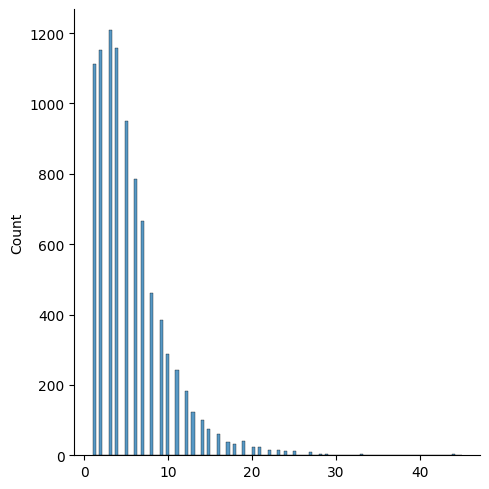

In [33]:
sns.displot(number_of_components)

### Biological Processes

What are the most common BP terms?

In [34]:
[
    (term_to_name[term], count)
    for term, count in Counter(p_words).most_common(10)
]

[('signal transduction', 809),
 ('positive regulation of transcription by RNA polymerase II', 796),
 ('regulation of transcription by RNA polymerase II', 789),
 ('G protein-coupled receptor signaling pathway', 757),
 ('negative regulation of transcription by RNA polymerase II', 591),
 ('positive regulation of DNA-templated transcription', 486),
 ('regulation of DNA-templated transcription', 417),
 ('detection of chemical stimulus involved in sensory perception of smell',
  404),
 ('apoptotic process', 399),
 ('protein phosphorylation', 397)]

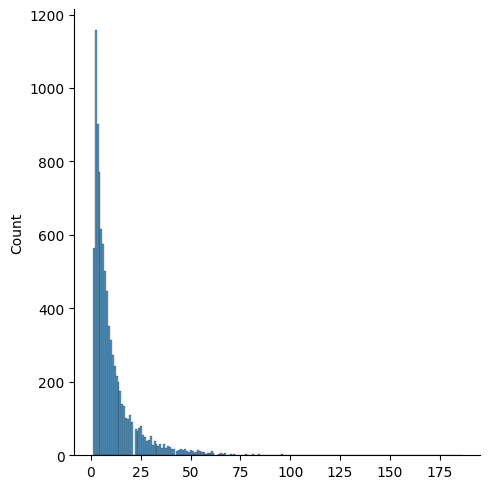

In [35]:
sns.displot(number_of_process)

### Molecular Functions

What are the most molecular function terms?

In [36]:
Counter(f_words).most_common(10)

[('GO:0005515', 6700),
 ('GO:0046872', 1271),
 ('GO:0005524', 1030),
 ('GO:0042802', 1020),
 ('GO:0003723', 800),
 ('GO:0000978', 659),
 ('GO:0000981', 616),
 ('GO:0003677', 576),
 ('GO:0004930', 558),
 ('GO:0042803', 500)]

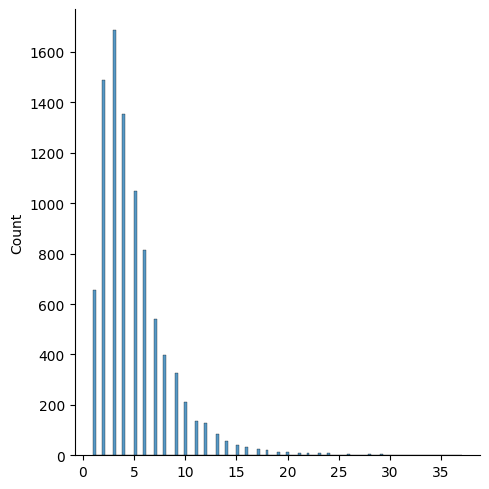

In [37]:
sns.displot(number_of_functions)

Since we're mostly interested in BPs, how many unique BPs are connected with proteins in our KG?

In [38]:
len(set(p_words))

11318

This is way too many. We'll have to find ways to filter them down.

## Drug-BP Labels

Next, we have drug-BP labels which were extracted from [ChEMBL](https://www.ebi.ac.uk/chembl/).

In [39]:
chembl_go = pd.read_csv(
    osp.join(MAPPING_DIR, "chembl_go.tsv"),
    sep="\t", 
    usecols=['chembl_idx', 'go_id', 'pchembl_value'],
    low_memory=False
)
chembl_go.head(5)

,chembl_idx,pchembl_value,go_id
0,CHEMBL344142,NaN,GO:0000166
1,CHEMBL344142,NaN,GO:0016491
2,CHEMBL400534,NaN,GO:0000166
3,CHEMBL400534,NaN,GO:0016491
4,CHEMBL3137945,NaN,GO:0000166


We only want the ones with a positive association, and that cutoff is a PChEMBL value of 6 or higher.

In [40]:
chembl_go = chembl_go.loc[chembl_go['pchembl_value'] >= 6]

Let's just take the columns we want since the df is so large.

In [41]:
chembl_go = chembl_go[['chembl_idx', 'go_id']]
# drop duplicates since some of them were distinct by assay ID:
chembl_go.drop_duplicates(inplace=True)

How many interactions do we have?

In [42]:
len(chembl_go)

9703547

Unique drugs?

In [43]:
len(chembl_go['chembl_idx'].unique())

398706

Unique GO terms?

In [44]:
chembl_go_terms = set(chembl_go['go_id'])
chembl_go_terms = chembl_go_terms - terms_to_remove
len(chembl_go_terms)

242

How many of these GO terms overlap with the GO BPs we found before?

Here I prune the protein-GO BP mappings to include only those proteins in the KG.

In [45]:
process_ids = {
    gene_idx: process_terms
    for gene_idx, process_terms in process_keywords.items() 
    if gene_idx in all_protein_in_kg
}

In [46]:
# GO BPs which are attached to the KG
go_bps = set.union(*process_ids.values())
# KG Proteins attached to these GO BPs
kg_prots_w_bps = set(process_ids.keys())
print(f"{len(go_bps)} GO BPs are attached to our KG.")

11318 GO BPs are attached to our KG.


In [47]:
bp_overlap = go_bps & chembl_go_terms
print(f"{len(go_bps)} of those GO BPs are also found in the drug-BP dataset from ChEMBL.")
len(bp_overlap)

11318 of those GO BPs are also found in the drug-BP dataset from ChEMBL.


63

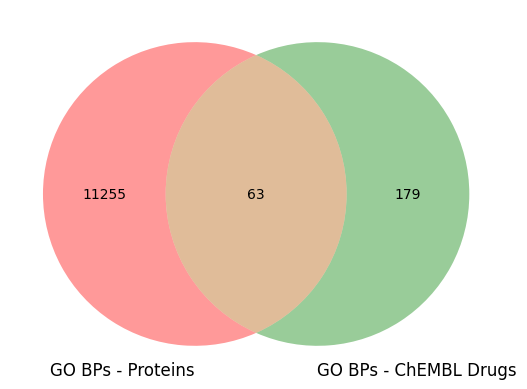

In [48]:
venn2_unweighted(
    [go_bps, chembl_go_terms],
    set_labels=['GO BPs - Proteins', 'GO BPs - ChEMBL Drugs']
)

And what if we only want to see those with drugs in our KG?

### Mapping KG drugs to those in our KG-BP dataset:

First, we need to do mappings between the PubChem IDs in our KG and the ChEMBL IDs here.

In [49]:
# Get all the KG drugs:
obl_drugs = {d for d in openbiolink_df['source'] if 'pubchem.compound' in d}
custom_drugs = {d for d in custom_df['source'] if 'pubchem.compound' in d}

In [50]:
len(custom_drugs)

218

In [51]:
len(obl_drugs)

211

In [52]:
all_drugs = custom_drugs.union(obl_drugs)

In [53]:
print(f"There are {len(all_drugs)} PubChem drugs in the KG.")

There are 272 PubChem drugs in the KG.


We need to get them without their prefixes:

In [54]:
cids = [cid.split(':')[1] for cid in all_drugs]

Now we map:

In [55]:
def get_pubchem_to_chembl(pubchemids: List[str], chunk_size=100):
    """Gets mappings from pubchem IDs to ChEMBL IDs.
    :param pubchemids: list of CIDs (numbers only, but in string format)
    :param chunk_size: the number of CIDs to query at once (100 is default and recommended)
    :returns: a dictionary mapping pubchem ID to ChEMBL ID. ChEMBL ID will be None if no mapping exists.
    """
    pubchem2chembl = {}
    for i in tqdm(range(0, len(pubchemids), chunk_size)):
        cids = ",".join([str(c) for c in pubchemids[i:i + chunk_size]])
        r = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cids}/xrefs/RegistryID/json')
        xrefs = r.json()['InformationList']['Information']
        for x in xrefs:
            if 'RegistryID' not in x:
                pubchem2chembl[x['CID']] = None
                continue
            m = re.search(r"(?!S)CHEMBL\d+", ' '.join(x['RegistryID']))
            chemblid = m.group(0) if m else None
            pubchem2chembl[x['CID']] = chemblid
    return pubchem2chembl


In [56]:
cid2chembl = get_pubchem_to_chembl(cids)
len(cid2chembl)

100%|██████████| 3/3 [00:43<00:00, 14.61s/it]


272

How many did not map?

In [57]:
len([i for i in cid2chembl.values() if i == None])

0

None of them! Fantastic. We have all the drugs in our KG as ChEMBL IDs. What if we subset the dataframe to have only the drugs in our KGs:

In [58]:
print(chembl_go.shape)
chembl_go = chembl_go[~chembl_go['go_id'].isin(terms_to_remove)]
print(chembl_go.shape)

(9703547, 2)
(8554925, 2)


In [59]:
# ChEMBL dataset with only rows containing one of the 240 drugs from our KG
usable_drug_bps = chembl_go.loc[chembl_go['chembl_idx'].isin(set(cid2chembl.values()))]

How many drugs does this leave us with?

In [60]:
print(f"{len(usable_drug_bps['chembl_idx'].unique())} drugs left between ChEMBL dataset and KG.")

133 drugs left between ChEMBL dataset and KG.


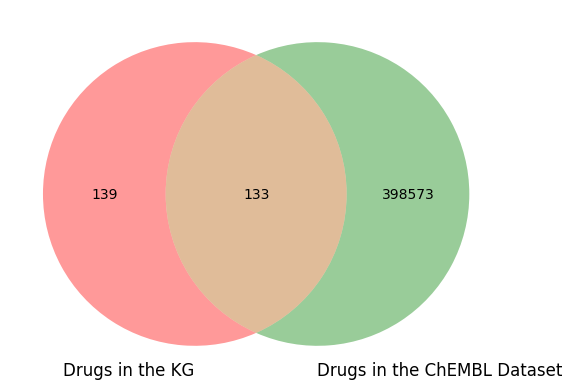

In [61]:
venn2_unweighted(
    [set(cid2chembl.values()), set(chembl_go['chembl_idx'].unique())],
    set_labels=['Drugs in the KG', 'Drugs in the ChEMBL Dataset']
)

Interactions?

In [62]:
print(f"{len(usable_drug_bps)} known drug-BP interactions left.")

4940 known drug-BP interactions left.


And BPs leftover?

In [63]:
chembl_go_terms = set(usable_drug_bps['go_id'])
len(chembl_go_terms)

184

In [64]:
bp_overlap = go_bps & chembl_go_terms
print(f"{len(bp_overlap)} GO BPs left between ChEMBL dataset and KG.")

61 GO BPs left between ChEMBL dataset and KG.


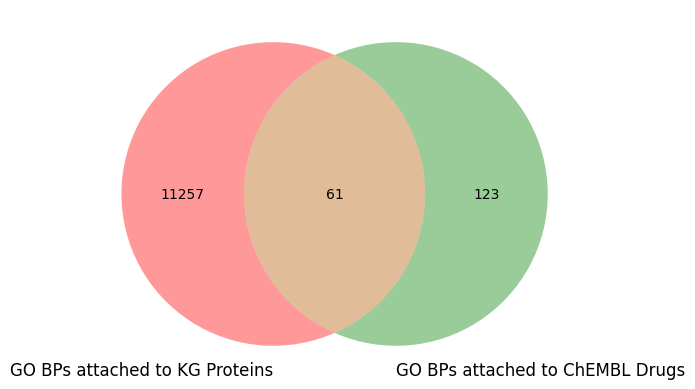

In [65]:
venn2_unweighted(
    [go_bps, chembl_go_terms],
    set_labels=['GO BPs attached to KG Proteins', 'GO BPs attached to ChEMBL Drugs']
)

That's still a good amount- we only lost one! Okay, let's just subset the dataframe to the GO BPs in the intersection and continue:

In [66]:
# ChEMBL dataset with only rows containing one of the 62 GO BPs attached to proteins in KG
usable_drug_bps = usable_drug_bps.loc[usable_drug_bps['go_id'].isin(bp_overlap)]

Let's investigate what the BP terms are and how many proteins/drugs each are connected to.

First, subset the GO ID to term dictionary:

In [67]:
sub_id2term = {key: val for key, val in id2term.items() if key in bp_overlap}
len(sub_id2term)

61

Next, get the number of drugs associated with each GO term:

In [68]:
go2drugno = Counter(usable_drug_bps['go_id'])

In [69]:
len(go2drugno)

61

And finally, get the number of proteins per GO term:

In [70]:
process_df

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
812115,9606,ncbigene:1,GO:0003674,ND,enables,molecular_function,-,Function
812116,9606,ncbigene:1,GO:0005576,HDA,located_in,extracellular region,27068509,Component
812117,9606,ncbigene:1,GO:0005576,IDA,located_in,extracellular region,3458201,Component
812118,9606,ncbigene:1,GO:0005576,TAS,located_in,extracellular region,-,Component
812119,9606,ncbigene:1,GO:0005615,HDA,located_in,extracellular space,16502470,Component
...,...,...,...,...,...,...,...,...
1157942,9606,ncbigene:125316803,GO:0005615,IDA,located_in,extracellular space,32958672,Component
1157943,9606,ncbigene:125316803,GO:0005730,IDA,located_in,nucleolus,32958672,Component
1157944,9606,ncbigene:127138866,GO:0003674,ND,enables,molecular_function,-,Function
1157945,9606,ncbigene:127138866,GO:0008150,ND,involved_in,biological_process,-,Process


In [71]:
usable_prot_bps = process_df.loc[process_df['GO_ID'].isin(bp_overlap) & process_df['GeneID'].isin(kg_prots_w_bps)]

In [72]:
# make sure there are only BPs in there:
usable_prot_bps['Category'].unique()

array(['Process'], dtype=object)

In [73]:
usable_prot_bps = usable_prot_bps[['GeneID', 'GO_ID']]
usable_prot_bps.drop_duplicates(inplace=True)
len(usable_prot_bps)

4296

In [74]:
go2protno = Counter(usable_prot_bps['GO_ID'])

In [75]:
len(go2protno)

61

In [76]:
feasible_go_bps = pd.DataFrame(sub_id2term.items(), columns=['go_id', 'go_term'])
feasible_go_bps['num_drugs'] = feasible_go_bps['go_id'].map(go2drugno)
feasible_go_bps['num_prots'] = feasible_go_bps['go_id'].map(go2protno)

In [77]:
feasible_go_bps

,go_id,go_term,num_drugs,num_prots
0,GO:0010951,negative regulation of endopeptidase activity,7,33
1,GO:0006805,xenobiotic metabolic process,34,92
2,GO:0006629,lipid metabolic process,64,104
3,GO:0055085,transmembrane transport,44,89
4,GO:0006914,autophagy,20,98
...,...,...,...,...
56,GO:0007017,microtubule-based process,46,13
57,GO:0022618,protein-RNA complex assembly,12,1
58,GO:0022607,cellular component assembly,32,1
59,GO:0007034,vacuolar transport,7,2


In [78]:
feasible_go_bps.to_csv(osp.join(KG_DIR, 'feasible_go_bps.tsv'), sep='\t')

In [79]:
print(f"{len(usable_drug_bps)} drug-BP interactions left.")

1708 drug-BP interactions left.


In [80]:
print(f"{len(usable_drug_bps['chembl_idx'].unique())} drugs left.")

132 drugs left.


What proportion of our dataset is positive labels?

In [81]:
len(usable_drug_bps) / (len(usable_drug_bps['chembl_idx'].unique()) * len(bp_overlap))

0.21212121212121213

## KG Combination

Here, I combine the various edge types to create one KG

Protein to Protein AND Compound to Protein Edges:

In [82]:
protein_kg = pd.concat([openbiolink_df, custom_df], ignore_index=True)

new_protein_kg = {'source': [],
                  'source_node_type': [],
                  'target': [],
                  'target_node_type': [],
                  'edge_type': []}

for i, row in protein_kg.iterrows():
    src_type = 'Compound' if 'compound' in row['source'] else 'Gene'
    snk_type = 'Gene'

    if src_type == 'Gene':  # if it's protein-protein
        edge_type = 'interacts'

        if row['polarity'] == -1:
            src = row['target']
            snk = row['source']
        else:
            src = row['source']
            snk = row['target']

    else:  # if it's compound-protein
        if row['polarity'] == -1:
            edge_type = 'downregulates'
        else:
            edge_type = 'upregulates'

        src = row['source']
        snk = row['target']

    new_protein_kg['source'].append(src)
    new_protein_kg['source_node_type'].append(src_type)
    new_protein_kg['target'].append(snk)
    new_protein_kg['target_node_type'].append(snk_type)
    new_protein_kg['edge_type'].append(edge_type)


new_protein_kg = pd.DataFrame(new_protein_kg)

In [83]:
new_protein_kg.head()

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Gene,upregulates
1,pubchem.compound:10607,Compound,ncbigene:203068,Gene,downregulates
2,pubchem.compound:10607,Compound,ncbigene:54658,Gene,downregulates
3,pubchem.compound:10607,Compound,ncbigene:7153,Gene,downregulates
4,pubchem.compound:10607,Compound,ncbigene:7277,Gene,downregulates


Gene to GO BP edges:

In [84]:
usable_prot_bps['source_node_type'] = ['Gene' for i in range(len(usable_prot_bps))]
usable_prot_bps['target_node_type'] = ['Biological Process' for i in range(len(usable_prot_bps))]
usable_prot_bps['edge_type'] = ['participates' for i in range(len(usable_prot_bps))]
usable_prot_bps.rename(columns={'GeneID': 'source',
                                'GO_ID': 'target'}, inplace=True)
usable_prot_bps = usable_prot_bps[['source', 'source_node_type', 'target','target_node_type', 'edge_type']]
usable_prot_bps.head(10)

,source,source_node_type,target,target_node_type,edge_type
812144,ncbigene:2,Gene,GO:0010951,Biological Process,participates
812166,ncbigene:9,Gene,GO:0006805,Biological Process,participates
812171,ncbigene:10,Gene,GO:0006805,Biological Process,participates
812184,ncbigene:12,Gene,GO:0010951,Biological Process,participates
812200,ncbigene:13,Gene,GO:0006629,Biological Process,participates
812201,ncbigene:13,Gene,GO:0006805,Biological Process,participates
812410,ncbigene:20,Gene,GO:0006629,Biological Process,participates
812440,ncbigene:20,Gene,GO:0055085,Biological Process,participates
812521,ncbigene:22,Gene,GO:0055085,Biological Process,participates
812568,ncbigene:24,Gene,GO:0055085,Biological Process,participates


Drug / Compound to GO BP edges:

Map the ChEMBL ids to Pubchem and create the relation table

In [85]:
chembl2cid = {
    val: key for key, val in cid2chembl.items() if val is not None
}

In [86]:
usable_drug_bps['pubchem'] = usable_drug_bps['chembl_idx'].map(chembl2cid)
usable_drug_bps['pubchem_idx'] = 'pubchem.compound:' + usable_drug_bps['pubchem'].astype(str)
usable_drug_bps = usable_drug_bps[['pubchem_idx', 'go_id']]
usable_drug_bps

,pubchem_idx,go_id
19875,pubchem.compound:5073,GO:0005975
19877,pubchem.compound:5073,GO:0007165
19878,pubchem.compound:5073,GO:0007267
19881,pubchem.compound:5073,GO:0008219
19886,pubchem.compound:5073,GO:0042592
...,...,...
80776048,pubchem.compound:444795,GO:0040011
81051785,pubchem.compound:456201,GO:0007165
81051790,pubchem.compound:456201,GO:0030154
81373718,pubchem.compound:24826799,GO:0006913


In [87]:
usable_drug_bps['source_node_type'] = ['Compound' for i in range(len(usable_drug_bps))]
usable_drug_bps['target_node_type'] = ['Biological Process' for i in range(len(usable_drug_bps))]
usable_drug_bps['edge_type'] = ['induces' for i in range(len(usable_drug_bps))]

usable_drug_bps.rename(columns={'pubchem_idx': 'source',
                                'go_id': 'target'}, inplace=True)
usable_drug_bps = usable_drug_bps[['source', 'source_node_type', 'target','target_node_type', 'edge_type']]
usable_drug_bps.head(10)

,source,source_node_type,target,target_node_type,edge_type
19875,pubchem.compound:5073,Compound,GO:0005975,Biological Process,induces
19877,pubchem.compound:5073,Compound,GO:0007165,Biological Process,induces
19878,pubchem.compound:5073,Compound,GO:0007267,Biological Process,induces
19881,pubchem.compound:5073,Compound,GO:0008219,Biological Process,induces
19886,pubchem.compound:5073,Compound,GO:0042592,Biological Process,induces
19888,pubchem.compound:5073,Compound,GO:0043085,Biological Process,induces
19891,pubchem.compound:5073,Compound,GO:0044281,Biological Process,induces
19893,pubchem.compound:5073,Compound,GO:0050877,Biological Process,induces
19894,pubchem.compound:5073,Compound,GO:0055085,Biological Process,induces
20020,pubchem.compound:60854,Compound,GO:0005975,Biological Process,induces


In [88]:
len(usable_drug_bps['source'].unique())

132

Merge all four dataframes:

In [89]:
frames = [new_protein_kg, usable_prot_bps, usable_drug_bps]

full_kg = pd.concat(frames, ignore_index=True)
full_kg.drop_duplicates(ignore_index=True, inplace=True)

full_kg.head(10)

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Gene,upregulates
1,pubchem.compound:10607,Compound,ncbigene:203068,Gene,downregulates
2,pubchem.compound:10607,Compound,ncbigene:54658,Gene,downregulates
3,pubchem.compound:10607,Compound,ncbigene:7153,Gene,downregulates
4,pubchem.compound:10607,Compound,ncbigene:7277,Gene,downregulates
5,pubchem.compound:10631,Compound,ncbigene:5241,Gene,upregulates
6,pubchem.compound:10635,Compound,ncbigene:10257,Gene,upregulates
7,pubchem.compound:10635,Compound,ncbigene:10645,Gene,upregulates
8,pubchem.compound:10635,Compound,ncbigene:2621,Gene,upregulates
9,pubchem.compound:10635,Compound,ncbigene:354,Gene,upregulates


In [90]:
len(full_kg)

96598

In [91]:
full_kg['edge_type'].unique()

array(['upregulates', 'downregulates', 'interacts', 'participates',
       'induces'], dtype=object)

In [92]:
full_kg.to_csv(osp.join(KG_DIR, 'full_kg.tsv'), sep='\t')